Learning to rank.

In [1]:
# set up Python
import logging
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import json
from plotnine import *
from wvu.util import plot_roc, threshold_plot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(383432)

In [3]:
example_name = 'uci wine example'

In [4]:
print(example_name)

uci wine example


In [5]:
if example_name=='uci wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('uci_wine_example_features.csv')
    features_scores = pd.read_csv('uci_wine_example_scores.csv')
    score_name = 'score'
    m_examples : int = 1000
    noise_scale = 8.7
    position_penalty_scale = -5.123
    simulation_sigma = 10.0
elif example_name=='sklearn wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('sklearn_wine_example_features.csv')
    features_scores = pd.read_csv('sklearn_wine_example_scores.csv')
    score_name = 'score'
    m_examples : int = 100
    noise_scale = 18.7
    position_penalty_scale = -13.123
    simulation_sigma = 10.0
else:
    raise("bad option")



In [6]:
features_frame.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
features_frame.shape

(6497, 11)

In [8]:


features_scores.head()

,score,quality_ge_7,quality
0,10.177865,0,5
1,9.856330,0,5
2,10.241983,0,5
3,12.145984,0,6
4,10.177865,0,5


In [9]:

n_alternatives : int = 5

In [10]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties

[-0.0, -5.123, -10.246, -15.369, -20.492]

In [11]:


n_vars : int = features_frame.shape[1] + len(position_penalties)


In [12]:
# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
    observations[f'display_position_{sel_i}'] = [sel_i] * m_examples
    selected_examples = rng.choice(features_frame.shape[0], size=m_examples, replace=True)
    observations[f'item_id_{sel_i}'] = selected_examples
    observations[f'score_value_{sel_i}'] = [  # noisy observation of score plus position penalty
        features_scores.loc[int(selected_examples[i]), score_name]                  # item score
        + position_penalties[sel_i] * rng.uniform(size=1, low=0, high=2)[0]  # positional penalty
        + noise_scale * rng.normal(size=1)[0]                                # observation noise
        for i in range(m_examples)
    ]
    observations[f'pick_value_{sel_i}'] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
    best_j = 0
    for j in range(1, n_alternatives):
        if observations[f'score_value_{j}'][i] > observations[f'score_value_{best_j}'][i]:
            best_j = j
    observations.loc[i, f'pick_value_{best_j}'] = 1

observations.head()

,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,0,4851,12.954273,1,1,1432,9.532130,0,2,1827,5.385228,0,3,1388,8.667941,0,4,4494,-35.777706,0
1,0,1458,24.793973,1,1,4841,0.923961,0,2,6102,-0.691119,0,3,1376,-3.620735,0,4,2797,-13.641305,0
2,0,4943,18.070494,0,1,4421,19.422742,1,2,4744,2.986495,0,3,4982,-9.911510,0,4,2408,-18.272229,0
3,0,1900,10.926330,0,1,1315,0.941807,0,2,1976,11.589271,1,3,68,-18.317898,0,4,4583,2.084345,0
4,0,5569,18.295666,0,1,1001,20.520523,1,2,1868,2.282048,0,3,5103,-14.600010,0,4,2704,-10.699963,0


In [13]:
observations.loc[:, [c for c in observations.columns if c.startswith('pick_value_')]].mean(axis=0)

pick_value_0    0.465
pick_value_1    0.255
pick_value_2    0.120
pick_value_3    0.082
pick_value_4    0.078
dtype: float64

In [14]:
observations[
    [c for c in observations.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_'))]
    ].head(10)

,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,0,1,1,0,2,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,0,0,1,1,2,0,3,0,4,0
3,0,0,1,0,2,1,3,0,4,0
4,0,0,1,1,2,0,3,0,4,0
5,0,0,1,1,2,0,3,0,4,0
6,0,0,1,1,2,0,3,0,4,0
7,0,0,1,1,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,0,1,1,0,2,0,3,0,4,0


In [15]:
# This is the data
observations[
    [c for c in observations.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_')) and (not c.startswith('display_position_'))]
    ].head(10)

,pick_value_0,pick_value_1,pick_value_2,pick_value_3,pick_value_4
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0
5,0,1,0,0,0
6,0,1,0,0,0
7,0,1,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [16]:
# swap all observed alternatives selections into picked position
observations_sorted = observations.copy()
for passed_i in range(1, n_alternatives):
    for row_i in range(m_examples):
        if observations_sorted.loc[row_i, f'pick_value_{passed_i}'] > 0:
            # swap where data is stored in row
            for dest_col, source_col in (
                ('display_position_0', f'display_position_{passed_i}'),
                ('item_id_0', f'item_id_{passed_i}'),
                ('score_value_0', f'score_value_{passed_i}'),
                ('pick_value_0', f'pick_value_{passed_i}'),
                ):
                v_source = observations_sorted.loc[row_i, source_col]
                v_dest = observations_sorted.loc[row_i, dest_col]
                observations_sorted.loc[row_i, source_col] = v_dest
                observations_sorted.loc[row_i, dest_col] = v_source


In [17]:
observations_sorted.head(10)


,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,0,4851,12.954273,1,1,1432,9.532130,0,2,1827,5.385228,0,3,1388,8.667941,0,4,4494,-35.777706,0
1,0,1458,24.793973,1,1,4841,0.923961,0,2,6102,-0.691119,0,3,1376,-3.620735,0,4,2797,-13.641305,0
2,1,4421,19.422742,1,0,4943,18.070494,0,2,4744,2.986495,0,3,4982,-9.911510,0,4,2408,-18.272229,0
3,2,1976,11.589271,1,1,1315,0.941807,0,0,1900,10.926330,0,3,68,-18.317898,0,4,4583,2.084345,0
4,1,1001,20.520523,1,0,5569,18.295666,0,2,1868,2.282048,0,3,5103,-14.600010,0,4,2704,-10.699963,0
5,1,3567,18.544539,1,0,1997,7.962495,0,2,3196,5.434913,0,3,6052,-19.146624,0,4,1229,-11.241397,0
6,1,2266,14.817567,1,0,4473,5.096899,0,2,5379,6.962810,0,3,6205,6.493744,0,4,6465,-2.924123,0
7,1,5413,8.972688,1,0,959,-6.822181,0,2,3090,2.605415,0,3,3825,-9.061283,0,4,973,-10.773502,0
8,0,4516,14.320579,1,1,4814,0.742294,0,2,5939,5.054662,0,3,4806,11.223152,0,4,5069,10.665145,0
9,0,933,22.470158,1,1,1096,6.256398,0,2,6092,16.013775,0,3,927,-16.117031,0,4,4342,8.263601,0


In [18]:
observations_sorted[
    [c for c in observations_sorted.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_'))]
    ].head(10)

,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,0,1,1,0,2,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,1,1,0,0,2,0,3,0,4,0
3,2,1,1,0,0,0,3,0,4,0
4,1,1,0,0,2,0,3,0,4,0
5,1,1,0,0,2,0,3,0,4,0
6,1,1,0,0,2,0,3,0,4,0
7,1,1,0,0,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,0,1,1,0,2,0,3,0,4,0


In [19]:
observations_sorted[
    [c for c in observations_sorted.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_')) and (not c.startswith('pick_value_'))]
    ].head(10)

,display_position_0,display_position_1,display_position_2,display_position_3,display_position_4
0,0,1,2,3,4
1,0,1,2,3,4
2,1,0,2,3,4
3,2,1,0,3,4
4,1,0,2,3,4
5,1,0,2,3,4
6,1,0,2,3,4
7,1,0,2,3,4
8,0,1,2,3,4
9,0,1,2,3,4


In [20]:
assert np.all(observations_sorted['pick_value_0'] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f'pick_value_{sel_i}'] == 0)

In [21]:
stan_model_src = (
"""
data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
"""
  + ''.join([f"""  matrix[m_examples, n_vars] x_passed_{i};   // character of passed examples
""" for i in range(1, n_alternatives)])
  + """}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
"""
  + ''.join([f"""  vector[m_examples] expect_passed_{i};
""" for i in range(1, n_alternatives)])
  + """  expect_picked = x_picked * beta;          // modeled expected score of picked item
  v_picked = expect_picked + error_picked;  // reified actual score of picked item
"""
  + ''.join([f"""  expect_passed_{i} = x_passed_{i} * beta;      // modeled expected score of passed item
""" for i in range(1, n_alternatives)])
  +"""}
model {
    // basic priors
  beta ~ normal(0, 10);
  error_picked ~ normal(0, 10);
    // log probability of observed ordering as a function of parameters
    // terms are independent conditioned on knowing value of v_picked!
"""
  + ''.join([f"""  target += normal_lcdf( v_picked | expect_passed_{i}, 10);
""" for i in range(1, n_alternatives)])
  + """}
"""
)


print(stan_model_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [22]:
stan_file = 'rank_src_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)

In [23]:
def fmt_array(a) -> str:
    return json.dumps([v for v in a])

def mk_posn_indicator(posn: int) -> str:
    posn_indicators = [0] * n_alternatives
    posn_indicators[posn] = 1
    return posn_indicators

def f_i(sel_i: int) -> str:
    id_seq = observations_sorted[f'item_id_{sel_i}']
    posn_seq = observations_sorted[f'display_position_{sel_i}']
    return fmt_array([
        list(features_frame.loc[int(id), :]) + mk_posn_indicator(int(posn))
        for id, posn in zip(id_seq, posn_seq)])

data_str = (f"""
{{
 "n_vars" : {n_vars},
 "m_examples" : {m_examples},
 "x_picked" : {f_i(0)},
"""
    + """,
""".join([f""" "x_passed_{i}" : {f_i(i)}""" for i in range(1, n_alternatives)])
    + """
}
"""
)

data_file = "rank_data_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [24]:
# build model

# instantiate the model object
model = CmdStanModel(stan_file=stan_file)
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
)

In [25]:
# get implied sample weights from chain
# this is double-counting weights as we would expect how often a sample path occurs to already
# encode probability. But we are seeing clearly not in the sweet spot chains that we must prune
# out. Their probabilities are so low, that if they were indeed being sample proportional to their
# probabilities- they just would not be here.
wt_frame = fit.draws_pd(vars=['lp__'])

wt_frame



,lp__
0,-1486.84
1,-1500.43
2,-1464.91
3,-1482.95
4,-1489.94
...,...
3995,-1529.91
3996,-1515.10
3997,-1550.31
3998,-1524.24


In [26]:
log_wt = wt_frame['lp__'] - np.max(wt_frame['lp__'])
row_sample_wt = log_wt >= -10 * np.log(wt_frame.shape[0])  # threshold, a little more reasonable than np.exp(log_wt)
row_sample_wt = row_sample_wt / np.sum(row_sample_wt)
wt_frame['row_sample_wt'] = row_sample_wt

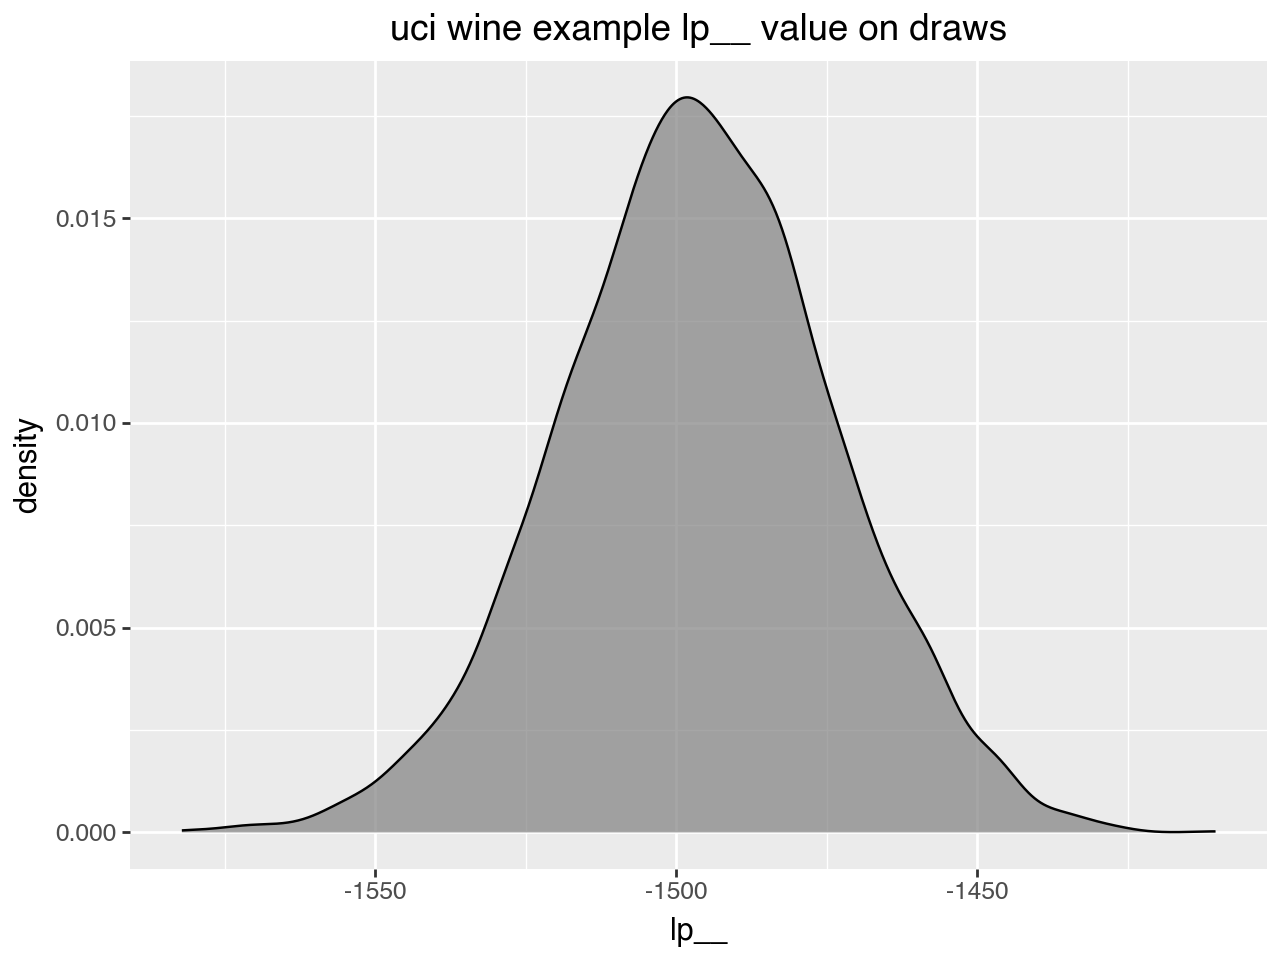

In [27]:
(
    ggplot(
        data=wt_frame,
        mapping=aes(x='lp__'),
    )
    + geom_density(fill='gray', alpha=0.7)
    + ggtitle(f'{example_name} lp__ value on draws')
)

In [28]:
beta_draws = fit.draws_pd(vars=['beta'])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [f'position_effect_{sel_i}' for sel_i in range(n_alternatives)]

beta_draws_display

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,-0.288510,-4.38652,-0.174078,0.034804,-0.609562,-0.003638,0.001164,-18.266800,2.831780,5.647970,1.14603,12.90250,7.433840,2.61911,1.816390,0.660316
1,0.142903,-6.17358,-1.830350,0.019643,2.023550,-0.023386,0.018359,17.692600,4.826470,-0.990413,1.68138,5.99029,2.189170,-3.24858,-6.501610,-6.506270
2,-0.381967,-1.99442,2.355530,0.159255,-3.339020,-0.037252,0.012416,-13.029400,2.519890,1.545840,1.34792,12.77290,7.676620,1.96702,0.464014,0.327336
3,-0.401799,-2.25199,2.829210,0.173870,-1.144210,-0.042662,0.013479,-18.273700,3.857090,2.337680,1.40670,12.81600,8.526280,3.58110,0.161843,-0.261489
4,-0.325817,-2.48106,-1.962830,0.136221,0.861713,0.004604,0.000102,11.770100,-1.552400,2.256870,1.31253,12.83250,8.273660,2.35253,1.181490,0.104213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.028506,-4.33711,0.619076,0.110868,-10.582100,0.007372,0.002161,-9.275300,5.038400,0.430653,0.94114,5.67245,0.324594,-5.40474,-6.676620,-9.325930
3996,-0.470505,-1.67737,1.070950,0.038557,-2.491760,0.033875,-0.013184,10.750000,-0.018566,1.369050,1.23828,11.20200,6.706240,1.00135,-0.482596,-2.045470
3997,-0.464501,-2.23771,2.310560,0.044699,-6.990760,-0.019733,-0.001597,11.622700,0.824360,-0.649322,1.37038,11.64970,6.424160,1.30844,-0.415921,-0.894778
3998,-0.229546,-2.83749,-0.712953,0.116881,-6.094270,0.026996,-0.006086,-11.196400,3.701900,0.797386,1.24857,8.58996,4.141110,-2.28670,-4.142500,-4.569180


In [29]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
beta_draws_display.mean()

fixed_acidity          -0.088468
volatile_acidity       -4.754351
citric_acid            -0.268307
residual_sugar          0.076102
chlorides              -1.873882
free_sulfur_dioxide    -0.010357
total_sulfur_dioxide    0.004178
density                -0.063806
pH                      2.744401
sulphates               1.516017
alcohol                 1.389067
position_effect_0       8.063514
position_effect_1       3.147290
position_effect_2      -2.028880
position_effect_3      -4.232316
position_effect_4      -4.635647
dtype: float64

In [30]:
estimated_beta = np.array(beta_draws.mul(row_sample_wt, axis=0).sum())
position_quantiles = (
    beta_draws
        .iloc[:, features_frame.shape[1]:n_vars]
        .quantile((0.25, 0.5, 0.75))
        .transpose()
        .reset_index(drop=True, inplace=False)
)
position_quantiles.columns = [str(c) for c in position_quantiles.columns]

In [31]:
position_effects_frame = pd.DataFrame({
    'position': [f'posn_{i}' for i in range(len(position_penalties))],
    'actual effect': position_penalties,
    'estimated effect': estimated_beta[features_frame.shape[1]:n_vars],
})
position_effects_frame = pd.concat([position_effects_frame, position_quantiles], axis=1)

position_effects_frame

,position,actual effect,estimated effect,0.25,0.5,0.75
0,posn_0,-0.000,8.063161,5.075102,8.110820,11.044500
1,posn_1,-5.123,3.169246,0.172708,3.169620,6.079945
2,posn_2,-10.246,-1.980753,-5.001368,-2.015205,0.893123
3,posn_3,-15.369,-4.156708,-7.183760,-4.208300,-1.276458
4,posn_4,-20.492,-4.555580,-7.653660,-4.557250,-1.674702


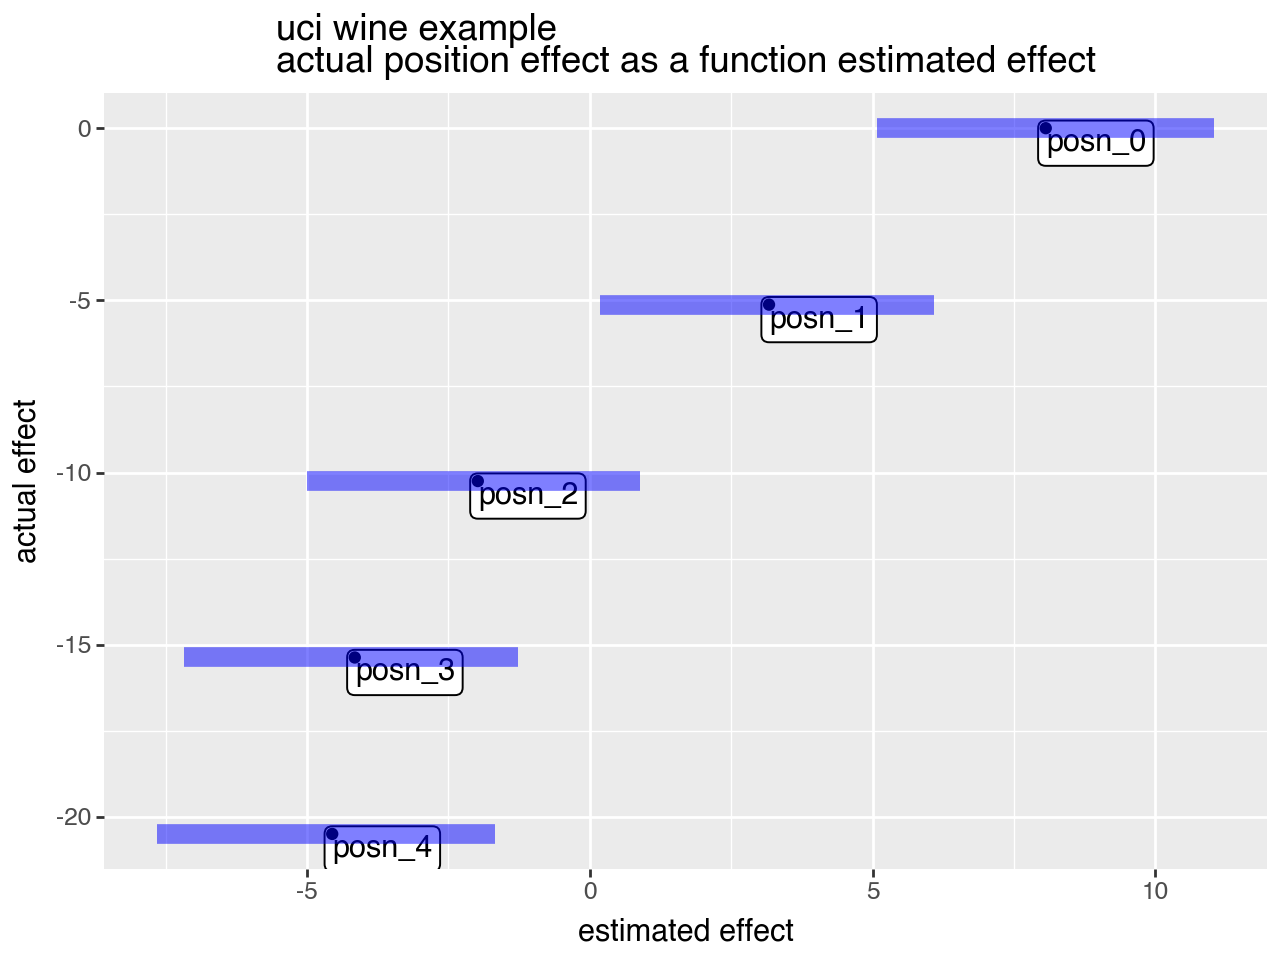

In [32]:
(
    ggplot(
        data=position_effects_frame,
        mapping=aes(
            x='estimated effect', 
            y='actual effect',
            label='position',
            ),
    )
    + geom_label(ha='left', va='top')
    + geom_point()
    + geom_segment(
        mapping=aes(yend='actual effect', x='0.25', xend='0.75'),
        color='blue',
        size=4,
        alpha=0.5,
    )
    + ggtitle(f'{example_name}\nactual position effect as a function estimated effect')
)

In [33]:
estimated_scores = pd.DataFrame({
    'estimated score': features_frame @ estimated_beta[range(features_frame.shape[1])],
    })

In [34]:
def p_select(row_i: int):
    n_draws: int  = 10000
    est_row = [
        estimated_scores.loc[int(observations.loc[row_i, f'item_id_{sel_i}']), 'estimated score']  # estimated per item score
        + position_effects_frame.loc[sel_i, 'estimated effect']                                    # estimated position effect
        for sel_i in range(n_alternatives)]
    est_picks = [0] * n_alternatives
    est_picks[np.argmax(est_row)] = 1
    draws = pd.DataFrame({
        f'est_{i}': rng.normal(loc=est_row[i], scale=simulation_sigma, size=n_draws) for i in range(n_alternatives)
    })
    draws_maxes = draws.max(axis=1)
    draws = pd.DataFrame({
        k: draws[k] >= draws_maxes for k in draws.columns
    })
    draws = draws.sum(axis=0)
    draws = draws / np.sum(draws)
    train_pick = [observations.loc[row_i, f'pick_value_{sel_i}'] == 1 for sel_i in range(n_alternatives)]
    return pd.DataFrame({
        'row': row_i,
        'position': range(n_alternatives),
        'pick probability estimate': draws,
        'was pick': train_pick
    })

pick_frame = [p_select(row_i) for row_i in range(observations.shape[0])]
pick_frame = pd.concat(pick_frame, ignore_index=True)
pick_frame.head(10)

,row,position,pick probability estimate,was pick
0,0,0,0.5263,True
1,0,1,0.2652,False
2,0,2,0.1004,False
3,0,3,0.0515,False
4,0,4,0.0566,False
5,1,0,0.4313,True
6,1,1,0.2822,False
7,1,2,0.2037,False
8,1,3,0.0333,False
9,1,4,0.0495,False


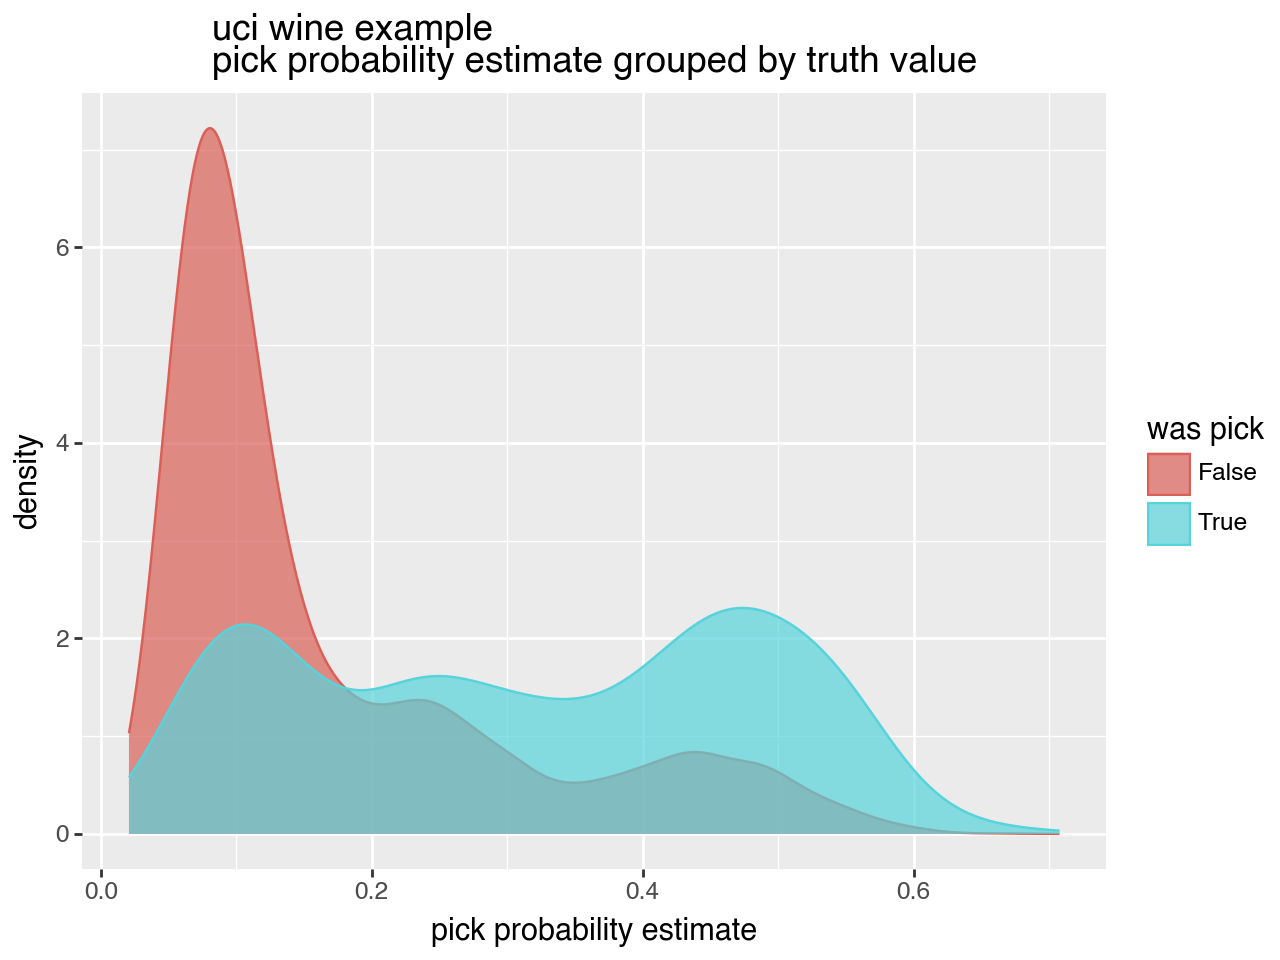

In [35]:
(
    ggplot(
        data=pick_frame,
        mapping=aes(
            x='pick probability estimate',
            color='was pick',
            fill='was pick',
        )
    )
    + geom_density(alpha=0.7)
    + ggtitle(f'{example_name}\npick probability estimate grouped by truth value')
)

<Figure size 640x480 with 0 Axes>

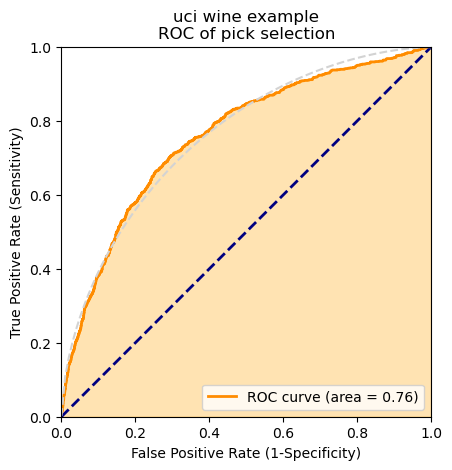

0.7581532499999999

In [36]:
plot_roc(
    prediction=pick_frame['pick probability estimate'],
    istrue=pick_frame['was pick'],
    ideal_line_color='lightgrey',
    title=f'{example_name}\nROC of pick selection',
)

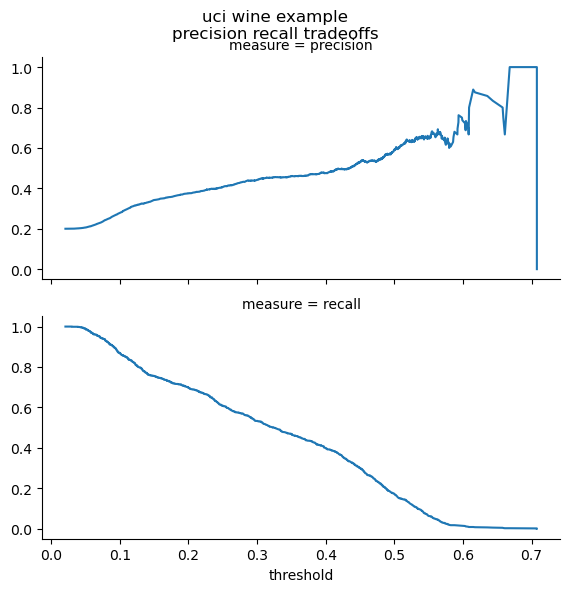

In [37]:
threshold_plot(
    pick_frame,
    pred_var='pick probability estimate',
    truth_var='was pick',
    plotvars=("precision", "recall"),
    title=f'{example_name}\nprecision recall tradeoffs',
)

In [38]:
score_compare_frame = pd.DataFrame({
    'original score': features_scores[score_name],
    'learned score': estimated_scores['estimated score'],
})

In [39]:
score_compare_frame.head()

,original score,learned score
0,10.177865,19.440008
1,9.856330,18.447817
2,10.241983,19.155393
3,12.145984,20.588349
4,10.177865,19.440008


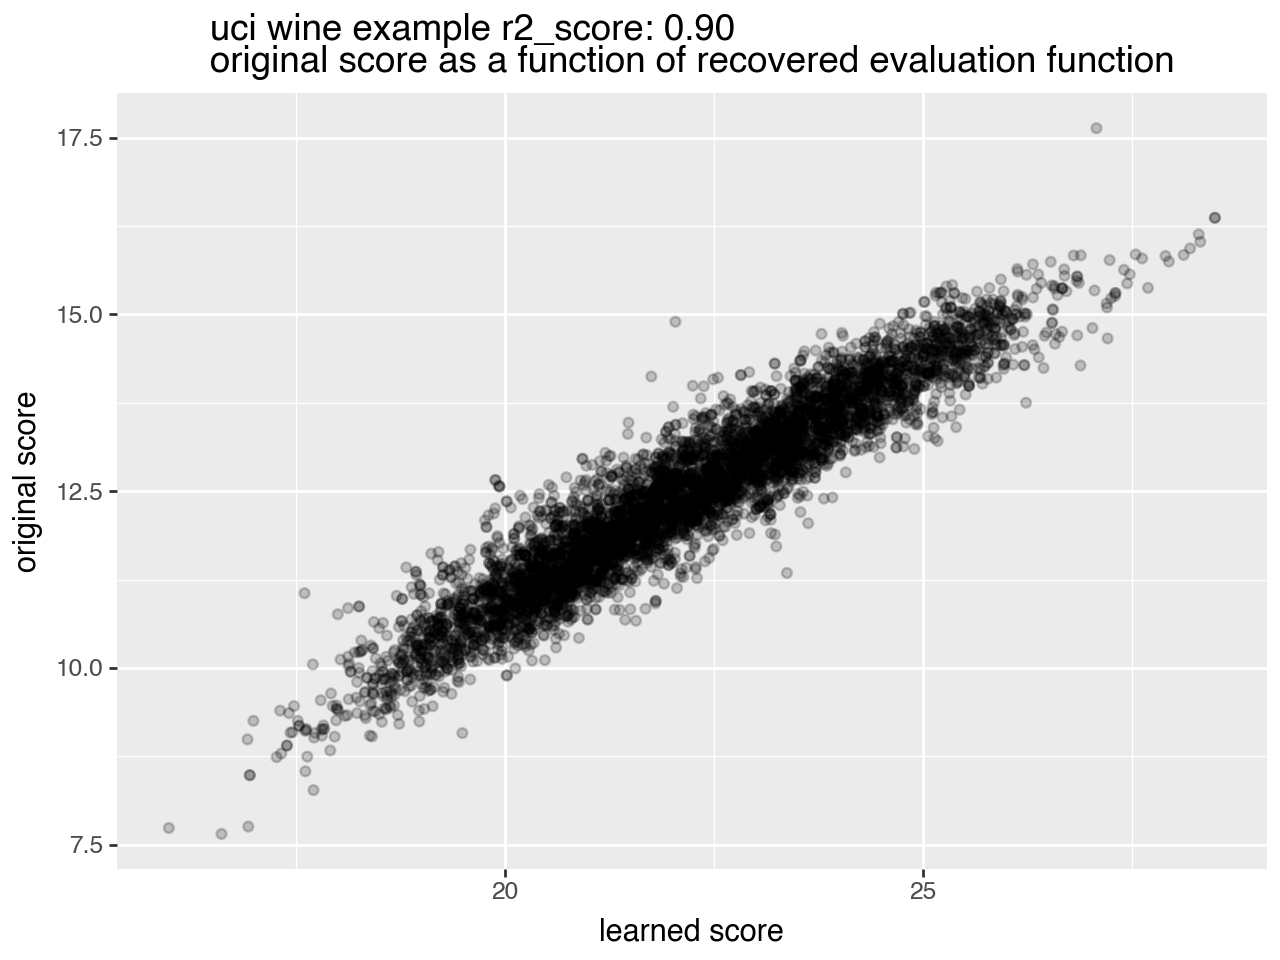

In [40]:
lin_model = LinearRegression()
lin_model.fit(
    score_compare_frame.loc[:, ['learned score']],
    score_compare_frame.loc[:, 'original score'],
)
r2_all = r2_score(
    y_true=score_compare_frame.loc[:, 'original score'],
    y_pred=lin_model.predict(score_compare_frame.loc[:, ['learned score']]),
)
(
    ggplot(
        data=score_compare_frame,
        mapping=aes(x='learned score', y='original score'),
    )
    + geom_point(alpha=0.2)
    + ggtitle(f'{example_name} r2_score: {r2_all:.2f}\noriginal score as a function of recovered evaluation function')
)

In [41]:
observed_ids = set(observations.loc[:, [c for c in observations.columns if c.startswith('item_id_')]].values.flatten())
unobserved_ids = [i for i in range(features_frame.shape[0]) if i not in observed_ids]

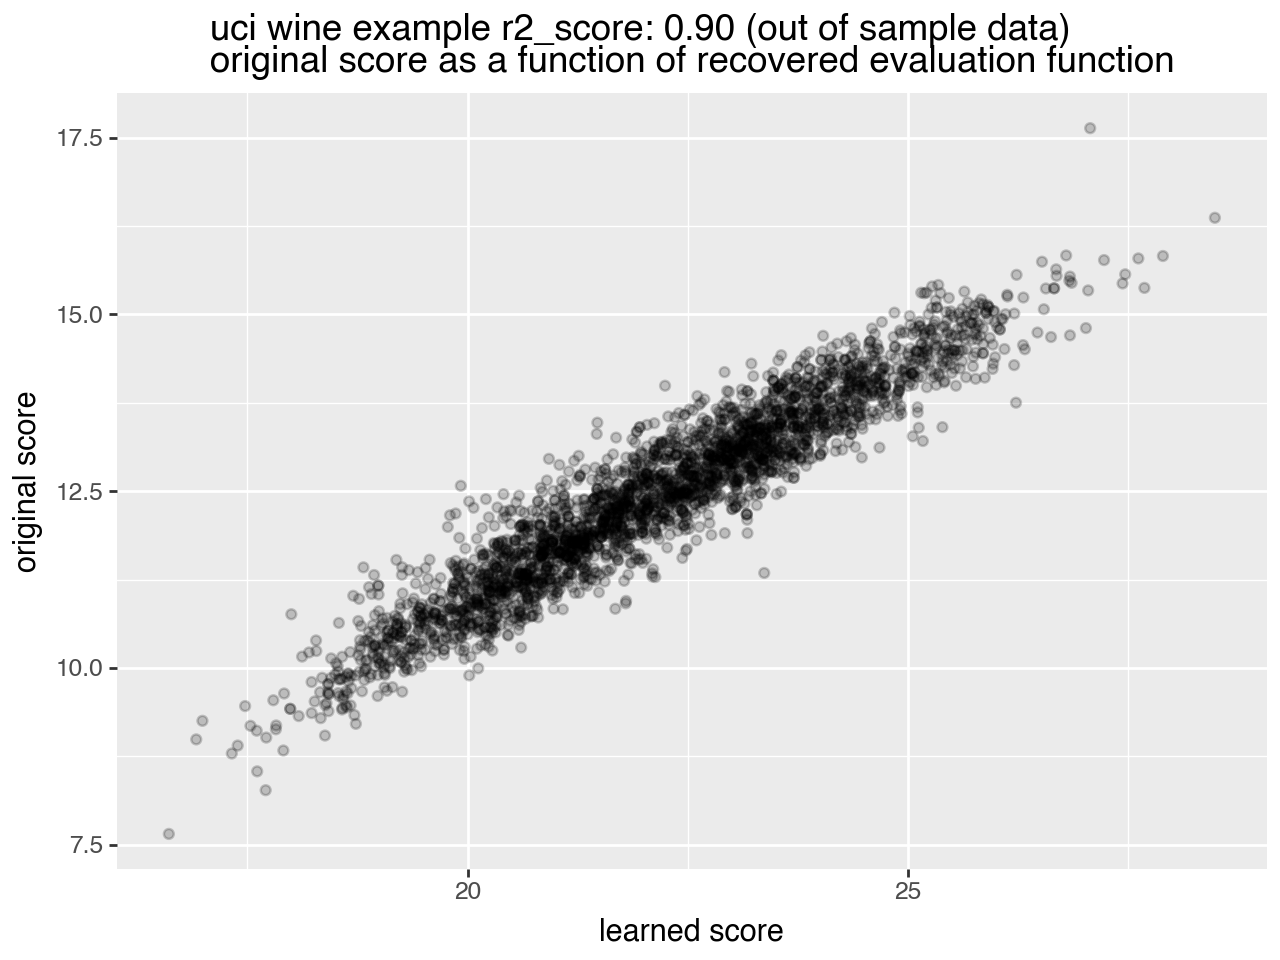

In [42]:
if len(unobserved_ids) > 10:
    score_compare_frame_test = score_compare_frame.loc[unobserved_ids, :].reset_index(drop=True, inplace=False)
    lin_model_test = LinearRegression()
    lin_model_test.fit(
        score_compare_frame_test.loc[:, ['learned score']],
        score_compare_frame_test.loc[:, 'original score'],
    )
    r2_out_of_sample = r2_score(
        y_true=score_compare_frame_test.loc[:, 'original score'],
        y_pred=lin_model_test.predict(score_compare_frame_test.loc[:, ['learned score']]),
    )
    (
        ggplot(
            data=score_compare_frame_test,
            mapping=aes(x='learned score', y='original score'),
        )
        + geom_point(alpha=0.2)
        + ggtitle(f'{example_name} r2_score: {r2_out_of_sample:.2f} (out of sample data)\noriginal score as a function of recovered evaluation function')
    ).show()

